<a href="https://colab.research.google.com/github/shashankpulijala/DeepLearning/blob/master/Copy_of_ImageSegm_CamVid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [0]:
# G

### Getting the Data from the path.... There are pngs and others from images and labels 

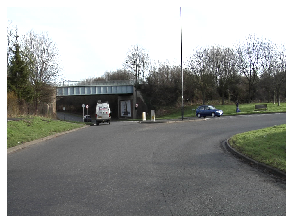

In [0]:
#file names from images 
fnames = get_image_files(path_img)
# labels 
label_names = get_image_files(path_lbl)
#showing 
img_files = fnames[0]
img = open_image(img_files)
img.show(figsize = (5,5))

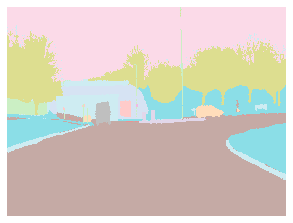

In [0]:
# For opening the label files use a mask
#fnames = get_image_files(path_img)
# labels 
#label_names = get_image_files(path_lbl)
#showing label files
#To open the y
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
mask = open_mask(get_y_fn(img_files))
mask.show(figsize = (5,5))

In [0]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Now the data has to be loaded as DataBunch using DataBlock API

In [0]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16270MB of GPU RAM free


In [0]:
#Using SegmentationItemList for segmentation purpose...
#As the validation data to be used is given by the dataset itself, using split_by_fname_file and filename as its param
#As this data is from Video we cannot randomly split data as there is a high chance of the train and valid being same
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
# 
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

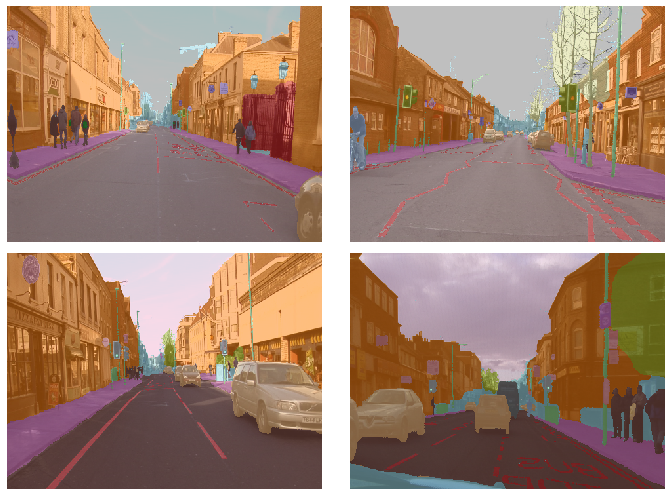

In [0]:
data.show_batch(2, figsize=(10,7))

In [0]:
### Building a model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid

In [0]:
wd=1e-2

In [0]:
### Using unetNet for CV for chaitanya

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 299MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


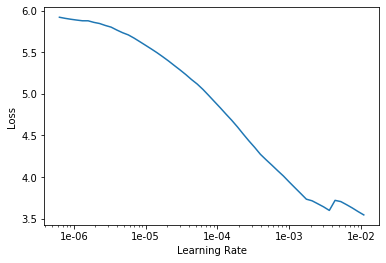

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 1e-04

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,3.721744,2.773481,0.351201,00:55
1,2.127053,1.377280,0.706442,00:51
2,1.341644,1.095191,0.780730,00:51
3,1.004512,0.773581,0.824831,00:52
4,0.827255,0.688932,0.841240,00:51
5,0.695141,0.609349,0.845903,00:51
6,0.624983,0.543727,0.858512,00:51
7,0.576623,0.476853,0.867158,00:51
8,0.542744,0.478793,0.865341,00:51
9,0.478013,0.401523,0.881657,00:51


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

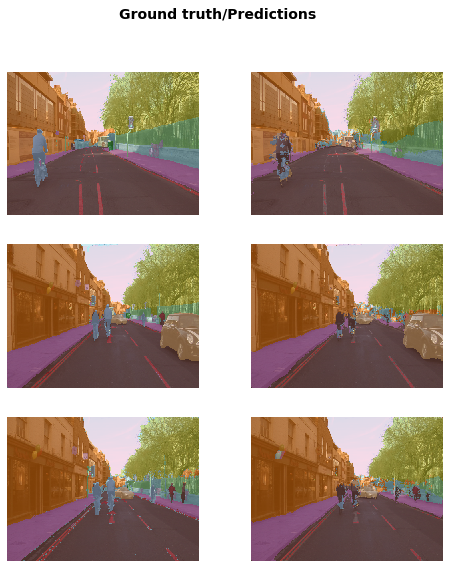

In [0]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()


In [0]:
lrs = slice(lr/400,lr/4)
lrs

slice(2.5e-07, 2.5e-05, None)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.441360,0.402758,0.878639,00:53
1,0.434256,0.402934,0.878623,00:53
2,0.438811,0.397905,0.880152,00:53
3,0.429155,0.396138,0.881472,00:53
4,0.423623,0.398841,0.879838,00:53
5,0.421604,0.378789,0.888203,00:54
6,0.408110,0.364062,0.891948,00:53
7,0.409359,0.368853,0.891083,00:53
8,0.392620,0.370573,0.890456,00:53
9,0.381281,0.365311,0.889686,00:53


In [0]:
learn.unfreeze()
lr = 1e-03
lrs = slice(lr/400,lr/4)
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.358315,0.350188,0.893863,00:53
1,0.365793,0.364619,0.888023,00:53
2,0.375372,0.368782,0.893118,00:53
3,0.385917,0.355834,0.897512,00:53
4,0.393403,0.422264,0.876406,00:53
5,0.398392,0.353012,0.902978,00:53
6,0.391653,0.385646,0.891934,00:53
7,0.383016,0.368695,0.895619,00:53
8,0.378813,0.319385,0.908254,00:53
9,0.350944,0.346075,0.898309,00:53


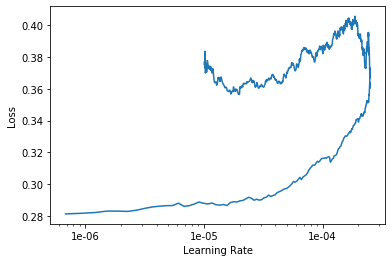

In [0]:
learn.recorder.plot()

In [0]:
learn.save('stage-2');

In [0]:
#Again from stage 2 weights
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 15565MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


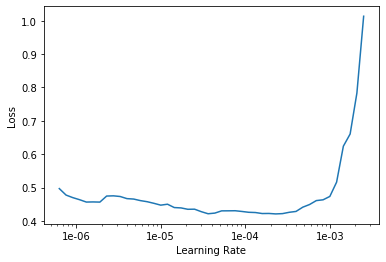

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)
learn.save('stage-1-big')
learn.load('stage-1-big');
learn.unfreeze()
lrs = slice(1e-6,lr/10)
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.391789,0.351440,0.895045,03:38


KeyboardInterrupt: ignored

In [0]:
learn.load('stage-2');

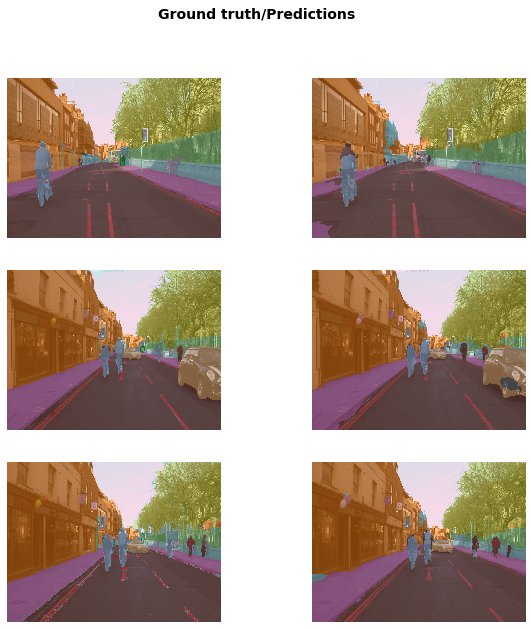

In [0]:
learn.show_results(rows=3, figsize=(10,10))